Loading All_IC_Curves_Summary.csv...
Found 159 unique cycles. Starting fitting...

>>> VISUALIZING FIT for spikeremoved_Cleaned_CY25-05_1-#1.xlsx - Cycle 1 <<<


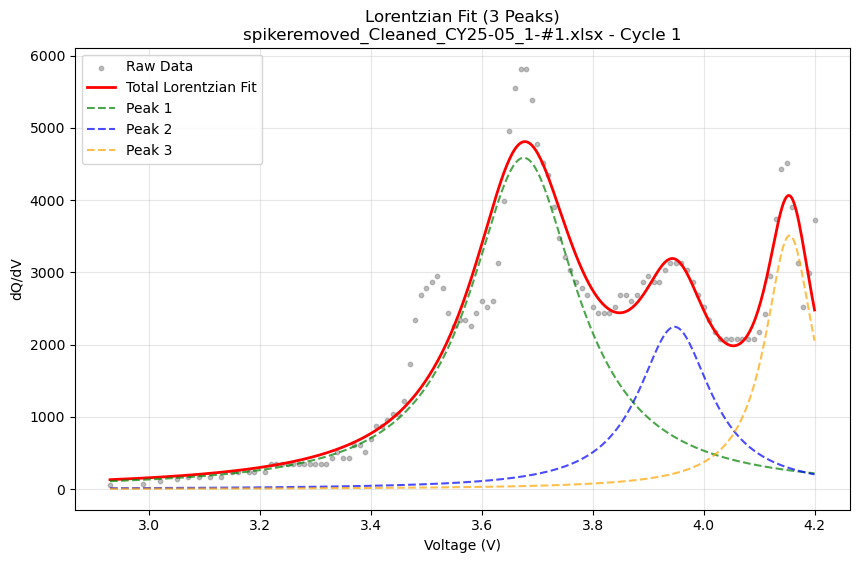

>>> Plot closed. Finishing remaining fits... <<<

Done! Fitted parameters for 154 cycles saved to 'Lorentzian_Features.csv'.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# --- CONFIG ---
INPUT_FILE = "All_IC_Curves_Summary.csv"
OUTPUT_FILE = "Lorentzian_Features.csv"
NUM_PEAKS = 3  # Number of peaks to fit

# --- 1. DEFINE LORENTZIAN FUNCTIONS ---
def lorentzian(x, A, x0, gamma):
    """
    A: Amplitude (Area under curve roughly)
    x0: Center Voltage
    gamma: Full Width at Half Maximum (FWHM)
    """
    return (A / np.pi) * ((gamma / 2) / ((x - x0)**2 + (gamma / 2)**2))

def multi_lorentzian(x, *params):
    """
    Sum of N lorentzians.
    params structure: [A1, x01, g1, A2, x02, g2, ...]
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        y += lorentzian(x, params[i], params[i+1], params[i+2])
    return y

def generate_initial_guesses(x_data, y_data, n_peaks=3):
    """
    Smartly guesses p0 by finding actual peaks in the data.
    """
    # Find peaks in the current signal to give curve_fit a head start
    peaks, properties = find_peaks(y_data, height=max(y_data)*0.1, distance=5)
    
    # Sort peaks by height (prominence)
    sorted_indices = np.argsort(properties['peak_heights'])[::-1]
    top_peaks = peaks[sorted_indices][:n_peaks]
    
    guesses = []
    
    # If we found fewer peaks than requested, fill with generic guesses distributed across range
    found_count = len(top_peaks)
    
    # Add found peaks first
    for idx in top_peaks:
        guesses.extend([y_data[idx], x_data[idx], 0.05]) # Guess Gamma=0.05V
        
    # Fill remaining spots with generic spaced peaks
    if found_count < n_peaks:
        x_min, x_max = min(x_data), max(x_data)
        missing = n_peaks - found_count
        step = (x_max - x_min) / (missing + 1)
        for i in range(missing):
            guesses.extend([max(y_data)/2, x_min + (i+1)*step, 0.05])
            
    # Sort guesses by voltage position (V0) to keep A1/V01 consistently the "first" peak
    # Reshape into triplets, sort by V0, flatten back
    triplets = [guesses[i:i+3] for i in range(0, len(guesses), 3)]
    triplets.sort(key=lambda x: x[1]) # Sort by V0
    flat_guesses = [item for sublist in triplets for item in sublist]
    
    return flat_guesses

# --- 2. LOAD DATA ---
print(f"Loading {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
except FileNotFoundError:
    print("Error: CSV file not found. Make sure you ran the previous script first.")
    exit()

results = []
plot_generated = False  # Flag to ensure we only plot once

# Group by File, Sheet, and Cycle
grouped = df.groupby(['Source_File', 'Sheet_Name', 'Cycle'])

print(f"Found {len(grouped)} unique cycles. Starting fitting...")

count = 0
for (source, sheet, cycle), group in grouped:
    # Prepare Data arrays
    # Drop NaNs and sort by Voltage just in case
    group = group.dropna(subset=['Voltage_V', 'dQ/dV']).sort_values('Voltage_V')
    
    x_val = group['Voltage_V'].values
    y_val = group['dQ/dV'].values
    
    if len(x_val) < 20:
        continue # Skip if not enough data points
        
    # Generate Initial Guess (Smart)
    p0 = generate_initial_guesses(x_val, y_val, NUM_PEAKS)
    
    # Boundaries (Optional but helps stability): 
    # A > 0, V within range, Gamma > 0
    # lower_bounds = [0, min(x_val), 0.001] * NUM_PEAKS
    # upper_bounds = [np.inf, max(x_val), 0.5] * NUM_PEAKS
    
    try:
        # Perform Fit
        popt, pcov = curve_fit(multi_lorentzian, x_val, y_val, p0=p0, maxfev=10000)
        
        # Store Results
        result_entry = {
            'Source_File': source,
            'Sheet_Name': sheet,
            'Cycle': cycle
        }
        
        # Unpack parameters into columns (A1, V1, G1, A2...)
        for i in range(NUM_PEAKS):
            idx = i * 3
            result_entry[f'Peak{i+1}_Amp'] = popt[idx]
            result_entry[f'Peak{i+1}_Pos'] = popt[idx+1]
            result_entry[f'Peak{i+1}_Width'] = popt[idx+2]
            
        results.append(result_entry)
        
        # --- VISUALIZATION (ONCE) ---
        if not plot_generated:
            print(f"\n>>> VISUALIZING FIT for {source} - Cycle {cycle} <<<")
            
            plt.figure(figsize=(10, 6))
            
            # 1. Original Data
            plt.scatter(x_val, y_val, s=10, color='gray', alpha=0.5, label='Raw Data')
            
            # 2. Total Fit
            x_smooth = np.linspace(min(x_val), max(x_val), 500)
            y_fit_total = multi_lorentzian(x_smooth, *popt)
            plt.plot(x_smooth, y_fit_total, 'r-', linewidth=2, label='Total Lorentzian Fit')
            
            # 3. Individual Peaks (to see what's happening under the hood)
            colors = ['green', 'blue', 'orange']
            for i in range(NUM_PEAKS):
                params_subset = popt[i*3 : (i+1)*3]
                y_peak = lorentzian(x_smooth, *params_subset)
                plt.plot(x_smooth, y_peak, '--', color=colors[i%3], alpha=0.7, label=f'Peak {i+1}')
            
            plt.title(f"Lorentzian Fit (3 Peaks)\n{source} - Cycle {cycle}")
            plt.xlabel("Voltage (V)")
            plt.ylabel("dQ/dV")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            plot_generated = True # Stop plotting
            print(">>> Plot closed. Finishing remaining fits... <<<")

    except RuntimeError:
        # print(f"Fit failed for {source} Cycle {cycle}")
        pass
    except Exception as e:
        print(f"Error on {source} Cycle {cycle}: {e}")

# --- SAVE RESULTS ---
if results:
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nDone! Fitted parameters for {len(results_df)} cycles saved to '{OUTPUT_FILE}'.")
else:
    print("No successful fits found.")

Loading All_IC_Curves_Summary.csv...
Found 395 unique cycles. Starting fitting...

>>> VISUALIZING FIT for spikeremoved_Cleaned_CY25-05_1-#1.xlsx - Cycle 1 <<<


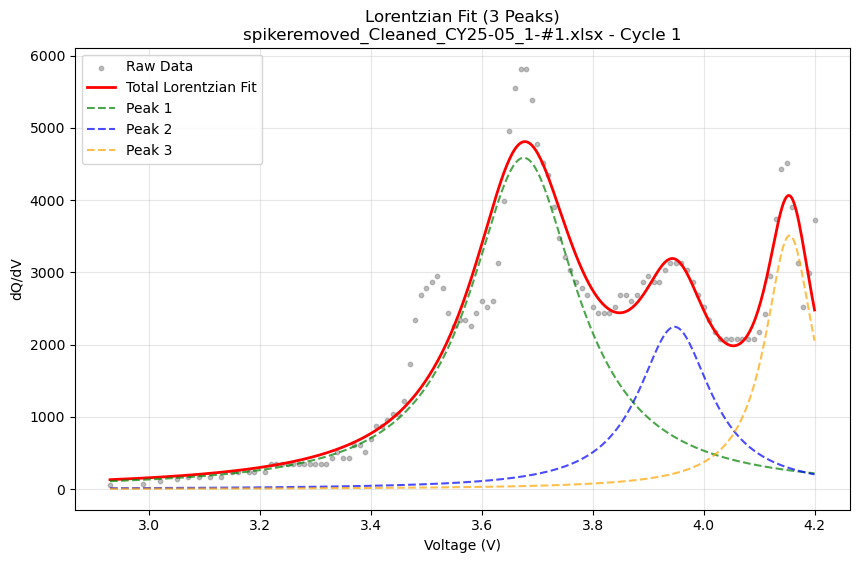

>>> Plot closed. Finishing remaining fits... <<<

Done! Fitted parameters for 392 cycles saved to 'Lorentzian_Features.csv'.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# --- CONFIG ---
INPUT_FILE = "All_IC_Curves_Summary.csv"
OUTPUT_FILE = "Lorentzian_Features.csv"
NUM_PEAKS = 3  # Number of peaks to fit

# --- 1. DEFINE LORENTZIAN FUNCTIONS ---
def lorentzian(x, A, x0, gamma):
    """
    A: Amplitude (Area under curve roughly)
    x0: Center Voltage
    gamma: Full Width at Half Maximum (FWHM)
    """
    return (A / np.pi) * ((gamma / 2) / ((x - x0)**2 + (gamma / 2)**2))

def multi_lorentzian(x, *params):
    """
    Sum of N lorentzians.
    params structure: [A1, x01, g1, A2, x02, g2, ...]
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        y += lorentzian(x, params[i], params[i+1], params[i+2])
    return y

def generate_initial_guesses(x_data, y_data, n_peaks=3):
    """
    Smartly guesses p0 by finding actual peaks in the data.
    """
    # Find peaks in the current signal to give curve_fit a head start
    peaks, properties = find_peaks(y_data, height=max(y_data)*0.1, distance=5)
    
    # Sort peaks by height (prominence)
    sorted_indices = np.argsort(properties['peak_heights'])[::-1]
    top_peaks = peaks[sorted_indices][:n_peaks]
    
    guesses = []
    
    # If we found fewer peaks than requested, fill with generic guesses distributed across range
    found_count = len(top_peaks)
    
    # Add found peaks first
    for idx in top_peaks:
        guesses.extend([y_data[idx], x_data[idx], 0.05]) # Guess Gamma=0.05V
        
    # Fill remaining spots with generic spaced peaks
    if found_count < n_peaks:
        x_min, x_max = min(x_data), max(x_data)
        missing = n_peaks - found_count
        step = (x_max - x_min) / (missing + 1)
        for i in range(missing):
            guesses.extend([max(y_data)/2, x_min + (i+1)*step, 0.05])
            
    # Sort guesses by voltage position (V0) to keep A1/V01 consistently the "first" peak
    # Reshape into triplets, sort by V0, flatten back
    triplets = [guesses[i:i+3] for i in range(0, len(guesses), 3)]
    triplets.sort(key=lambda x: x[1]) # Sort by V0
    flat_guesses = [item for sublist in triplets for item in sublist]
    
    return flat_guesses

# --- 2. LOAD DATA ---
print(f"Loading {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
except FileNotFoundError:
    print("Error: CSV file not found. Make sure you ran the previous script first.")
    exit()

results = []
plot_generated = False  # Flag to ensure we only plot once

# Group by File, Sheet, and Cycle
grouped = df.groupby(['Source_File', 'Sheet_Name', 'Cycle'])

print(f"Found {len(grouped)} unique cycles. Starting fitting...")

count = 0
for (source, sheet, cycle), group in grouped:
    # Prepare Data arrays
    # Drop NaNs and sort by Voltage just in case
    group = group.dropna(subset=['Voltage_V', 'dQ/dV']).sort_values('Voltage_V')
    
    x_val = group['Voltage_V'].values
    y_val = group['dQ/dV'].values
    
    if len(x_val) < 20:
        continue # Skip if not enough data points
        
    # Generate Initial Guess (Smart)
    p0 = generate_initial_guesses(x_val, y_val, NUM_PEAKS)
    
    # Boundaries (Optional but helps stability): 
    # A > 0, V within range, Gamma > 0
    # lower_bounds = [0, min(x_val), 0.001] * NUM_PEAKS
    # upper_bounds = [np.inf, max(x_val), 0.5] * NUM_PEAKS
    
    try:
        # Perform Fit
        popt, pcov = curve_fit(multi_lorentzian, x_val, y_val, p0=p0, maxfev=10000)
        
        # Store Results
        result_entry = {
            'Source_File': source,
            'Sheet_Name': sheet,
            'Cycle': cycle
        }
        
        # Unpack parameters into columns (A1, V1, G1, A2...)
        for i in range(NUM_PEAKS):
            idx = i * 3
            result_entry[f'Peak{i+1}_Amp'] = popt[idx]
            result_entry[f'Peak{i+1}_Pos'] = popt[idx+1]
            result_entry[f'Peak{i+1}_Width'] = popt[idx+2]
            
        results.append(result_entry)
        
        # --- VISUALIZATION (ONCE) ---
        if not plot_generated:
            print(f"\n>>> VISUALIZING FIT for {source} - Cycle {cycle} <<<")
            
            plt.figure(figsize=(10, 6))
            
            # 1. Original Data
            plt.scatter(x_val, y_val, s=10, color='gray', alpha=0.5, label='Raw Data')
            
            # 2. Total Fit
            x_smooth = np.linspace(min(x_val), max(x_val), 500)
            y_fit_total = multi_lorentzian(x_smooth, *popt)
            plt.plot(x_smooth, y_fit_total, 'r-', linewidth=2, label='Total Lorentzian Fit')
            
            # 3. Individual Peaks (to see what's happening under the hood)
            colors = ['green', 'blue', 'orange']
            for i in range(NUM_PEAKS):
                params_subset = popt[i*3 : (i+1)*3]
                y_peak = lorentzian(x_smooth, *params_subset)
                plt.plot(x_smooth, y_peak, '--', color=colors[i%3], alpha=0.7, label=f'Peak {i+1}')
            
            plt.title(f"Lorentzian Fit (3 Peaks)\n{source} - Cycle {cycle}")
            plt.xlabel("Voltage (V)")
            plt.ylabel("dQ/dV")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            plot_generated = True # Stop plotting
            print(">>> Plot closed. Finishing remaining fits... <<<")

    except RuntimeError:
        # print(f"Fit failed for {source} Cycle {cycle}")
        pass
    except Exception as e:
        print(f"Error on {source} Cycle {cycle}: {e}")

# --- SAVE RESULTS ---
if results:
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_FILE, index=False)
    print(f"\nDone! Fitted parameters for {len(results_df)} cycles saved to '{OUTPUT_FILE}'.")
else:
    print("No successful fits found.")